# Project 3: Reddit Post Sorting

- **ExplainLikeImFive (ELI5)** - Explain Like I'm Five is the best forum and archive on the internet for layperson-friendly explanations. Don't Panic!
- **AskScience** - Ask a science question, get a science answer.


---

We will be analyzing a random collection of posts from two subReddits, **ExplainLikeImFive** and **AskScience**, in order to build a model to predict if an individual posts belong to ELI5 or AskScience; we will be analyzing the Title and Body of the Post.

**What am I hoping to achieve with this?**
> If ELI5 is distinguishable from AskScience.

**Why?**
> To see if a subreddit focused on explaining things in a simple manner is that much different than a subreddit that wants to explain it any way they can.

# Data Cleaning and Exploratory Data Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords

from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [2]:
ex_df = pd.read_csv('../data/ex_df.csv')
ex_df.head()

,author,created_utc,id,selftext,subreddit,title
0,j_d0tnet,1631248750,ple5nz,Disclaimer: I did see a previous question touc...,explainlikeimfive,"ELI5: Seriously, WTF is up with surface area a..."
1,ImpossibleZero,1631247022,pldqkn,I have a 30 year VA loan at 3.75% and my prope...,explainlikeimfive,ELI5: What does Refinancing a Mortgage Mean an...
2,80sKidCA,1631246964,pldq29,NaN,explainlikeimfive,ELI5: Why and how does your body store tension...
3,Chardington,1631244279,pld1sd,"I’ve been getting into finance, stonks and cry...",explainlikeimfive,ELI5: What exactly is “liquidity”?
4,DentonJoe,1631244183,pld0wi,Always wondered why it doesn’t make sense to u...,explainlikeimfive,Eli5 why are diesel/electric powertrains econo...


In [3]:
ask_df = pd.read_csv('../data/ask_df.csv')
ask_df.head()

,author,created_utc,id,selftext,subreddit,title
0,ChrisGnam,1630428742,pf9tvb,So most of my peers (26 y/o and older) don't h...,askscience,Are there physiological or psychological diffe...
1,MaoGo,1629571284,p8wued,Neutrinos are neutrally charged particles that...,askscience,How do we know that the neutrinos have spin?
2,the_protagonist,1629571059,p8ws1c,How does that “memory” work? \n\nThis comes f...,askscience,If white blood cells are constantly dying and ...
3,CyKii,1629567841,p8vtoe,Obviously it's best to be careful about these ...,askscience,"If mRNA vaccines remain proven safe, is it act..."
4,hairycoo,1629566821,p8vinv,NaN,askscience,Can't we include multiple virus traits rather ...


**Data was read in successfully**

Let's ensure we dont have any removed posts.

In [4]:
ex_df[ex_df['selftext']!= '[removed]'].shape

(10000, 6)

In [5]:
ask_df[ask_df['selftext']!= '[removed]'].shape

(10095, 6)

## Data Cleaning

**Check for Missing Values and Incorrect Datatypes**

In [6]:
ex_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   author       10000 non-null  object
 1   created_utc  10000 non-null  int64 
 2   id           10000 non-null  object
 3   selftext     5100 non-null   object
 4   subreddit    10000 non-null  object
 5   title        10000 non-null  object
dtypes: int64(1), object(5)
memory usage: 468.9+ KB


In [7]:
ask_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10095 entries, 0 to 10094
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   author       10095 non-null  object
 1   created_utc  10095 non-null  int64 
 2   id           10095 non-null  object
 3   selftext     6802 non-null   object
 4   subreddit    10095 non-null  object
 5   title        10095 non-null  object
dtypes: int64(1), object(5)
memory usage: 473.3+ KB


**We appear to have some empty selftext variables, which represent the body of the post. These posts without any selftext would only provide value through the title, and may be difficult for our model to analyze. 
> Since we still have a significant amount of data without these posts, we will remove posts without selftext.**

In [8]:
ex_df.dropna(inplace=True)
ask_df.dropna(inplace=True)

In [9]:
ex_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5100 entries, 0 to 9998
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   author       5100 non-null   object
 1   created_utc  5100 non-null   int64 
 2   id           5100 non-null   object
 3   selftext     5100 non-null   object
 4   subreddit    5100 non-null   object
 5   title        5100 non-null   object
dtypes: int64(1), object(5)
memory usage: 278.9+ KB


In [10]:
ask_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6802 entries, 0 to 10091
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   author       6802 non-null   object
 1   created_utc  6802 non-null   int64 
 2   id           6802 non-null   object
 3   selftext     6802 non-null   object
 4   subreddit    6802 non-null   object
 5   title        6802 non-null   object
dtypes: int64(1), object(5)
memory usage: 372.0+ KB


## Exploratory Data Analysis

**Let's do some NLP exploration on our two datasets.**

We will define 2 functions to perform our analysis for length of the Title and Body of the posts.

In [11]:
def word_len(df, column):
    '''
    Takes the dataframe and column to be measured and adds a new column to that dataframe.
    '''
    words = []
    for status in df[column]:
        words.append(len(status.split(' ')))

    df[column+'_words'] = words
    
    return df

In [12]:
def char_len(df, column):

    status_length = []
    for status in df[column]:
        status_length.append(len(status))


    df[column+'_len'] = status_length

    return df

---

**How long are the titles on average?**

In [13]:
ex_df = word_len(ex_df, 'title')
ex_df = char_len(ex_df, 'title')
print(f"For the ELI5 SubReddit, Average length of Title is {round(ex_df['title_words'].mean())} words, or {round(ex_df['title_len'].mean())} characters.")

For the ELI5 SubReddit, Average length of Title is 13 words, or 71 characters.


In [14]:
ask_df = word_len(ask_df, 'title')
ask_df = char_len(ask_df, 'title')
print(f"For the AskScience SubReddit, Average length of Title is {round(ask_df['title_words'].mean())} words, or {round(ask_df['title_len'].mean())} characters.")

For the AskScience SubReddit, Average length of Title is 14 words, or 81 characters.


**How long are the bodies (selftext) of the submission on average?**

In [15]:
ex_df = word_len(ex_df, 'selftext')
ex_df = char_len(ex_df, 'selftext')
print(f"For the ELI5 SubReddit, Average length of Selftext is {round(ex_df['selftext_words'].mean())} words, or {round(ex_df['selftext_len'].mean())} characters.")

For the ELI5 SubReddit, Average length of Selftext is 46 words, or 252 characters.


In [16]:
ask_df = word_len(ask_df, 'selftext')
ask_df = char_len(ask_df, 'selftext')
print(f"For the AskScience SubReddit, Average length of Selftext is {round(ask_df['selftext_words'].mean())} words, or {round(ask_df['selftext_len'].mean())} characters.")

For the AskScience SubReddit, Average length of Selftext is 62 words, or 361 characters.


**Let's see some additional numerical descriptions for these newly created columns.**

In [17]:
ask_df.describe()

,created_utc,title_words,title_len,selftext_words,selftext_len
count,6.802000e+03,6802.000000,6802.000000,6802.000000,6802.000000
mean,1.509692e+09,14.130550,81.276389,61.548662,361.237136
std,2.997119e+07,7.742759,43.499165,61.587431,373.724661
min,1.483134e+09,2.000000,13.000000,1.000000,1.000000
25%,1.492331e+09,9.000000,51.000000,26.000000,144.000000
50%,1.500948e+09,12.000000,71.000000,45.000000,260.000000
75%,1.515098e+09,18.000000,102.000000,77.000000,447.000000
max,1.630429e+09,60.000000,299.000000,1107.000000,6653.000000


In [18]:
ex_df.describe()

,created_utc,title_words,title_len,selftext_words,selftext_len
count,5.100000e+03,5100.000000,5100.000000,5100.000000,5100.000000
mean,1.626993e+09,12.760392,71.155294,45.689412,252.258039
std,2.402123e+06,7.112896,39.127639,36.634624,205.534420
min,1.622887e+09,1.000000,11.000000,1.000000,1.000000
25%,1.624961e+09,8.000000,45.000000,22.000000,118.000000
50%,1.626889e+09,11.000000,62.000000,37.000000,198.000000
75%,1.629050e+09,16.000000,88.000000,59.000000,324.000000
max,1.631249e+09,54.000000,299.000000,440.000000,2341.000000


**Nothing too out of line here. We see at least 1 very long selftext and title, but nothing too worrisome.**

---

**What is the distribution of title and selftext lengths and word counts?**

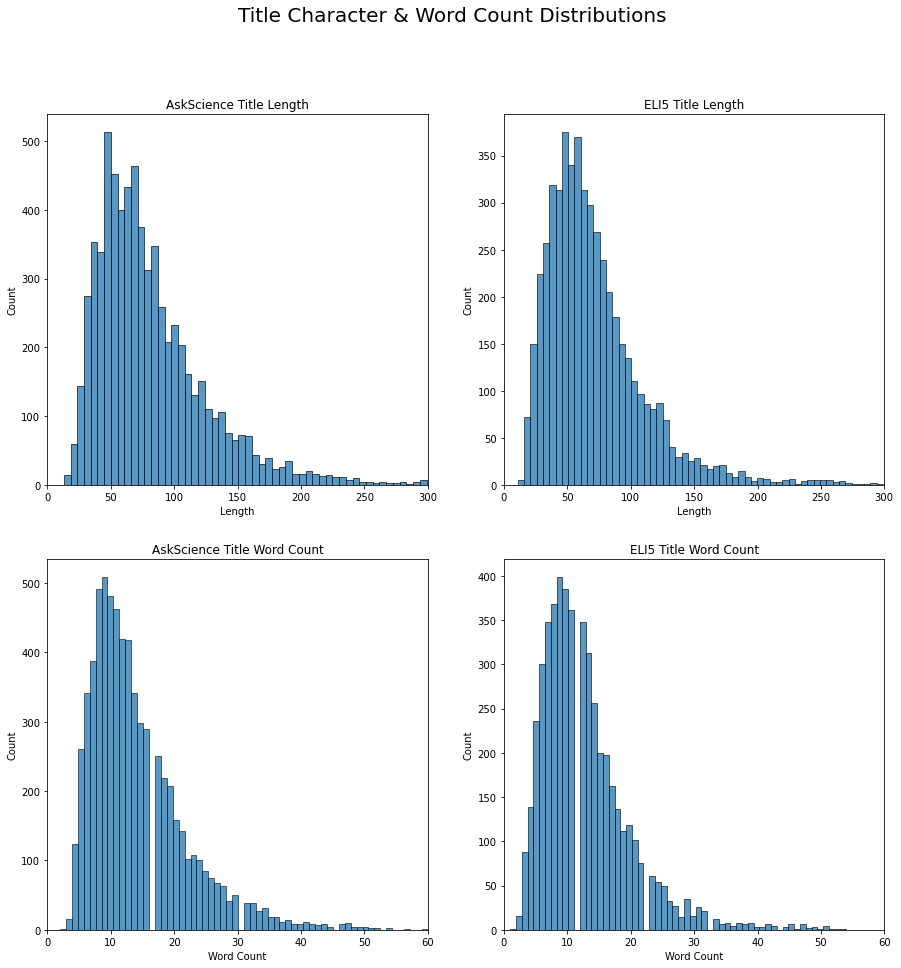

In [19]:
fig, ax = plt.subplots(2, 2, figsize=(15,15))
sns.histplot(ask_df['title_len'], ax=ax[0,0])
sns.histplot(ex_df['title_len'], ax=ax[0,1])
sns.histplot(ask_df['title_words'], ax=ax[1,0])
sns.histplot(ex_df['title_words'], ax=ax[1,1])

ax[0,0].set(xlabel='Length', xlim=[0,300], title='AskScience Title Length')
ax[0,1].set(xlabel='Length', xlim=[0,300], title='ELI5 Title Length')
ax[1,0].set(xlabel='Word Count', xlim=[0,60], title='AskScience Title Word Count')
ax[1,1].set(xlabel='Word Count', xlim=[0,60], title='ELI5 Title Word Count')

fig.suptitle('Title Character & Word Count Distributions', fontsize=20);

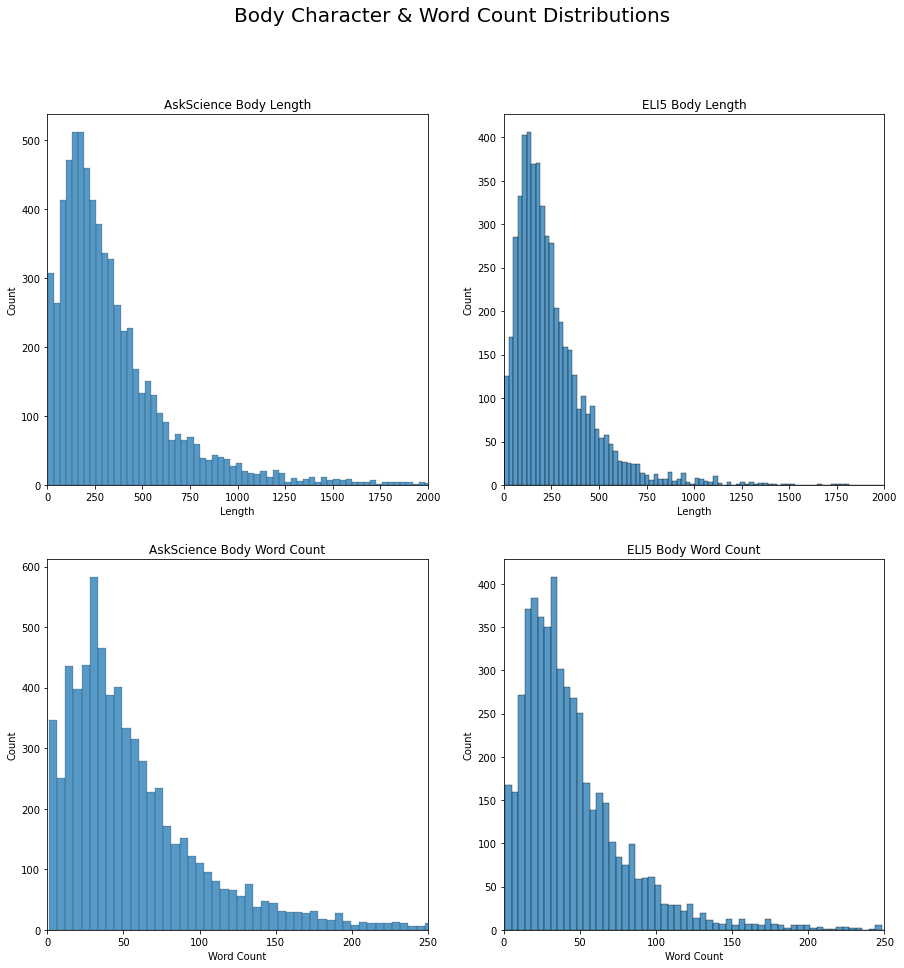

In [20]:
fig, ax = plt.subplots(2, 2, figsize=(15,15))
sns.histplot(ask_df['selftext_len'], ax=ax[0,0])
sns.histplot(ex_df['selftext_len'], ax=ax[0,1])
sns.histplot(ask_df['selftext_words'], ax=ax[1,0])
sns.histplot(ex_df['selftext_words'], ax=ax[1,1])

ax[0,0].set(xlabel='Length', xlim=[0,2000], title='AskScience Body Length')
ax[0,1].set(xlabel='Length', xlim=[0,2000], title='ELI5 Body Length')
ax[1,0].set(xlabel='Word Count', xlim=[0,250], title='AskScience Body Word Count')
ax[1,1].set(xlabel='Word Count', xlim=[0,250], title='ELI5 Body Word Count')

fig.suptitle('Body Character & Word Count Distributions', fontsize=20);

---

### For our analysis, we would benefit from having title and selftext in the same field for our model to analyze. The combined distribution will also be interesting.

In [21]:
ask_df['combo'] = ask_df['title'] + ' ' + ask_df['selftext']
ask_df.head()

,author,created_utc,id,selftext,subreddit,title,title_words,title_len,selftext_words,selftext_len,combo
0,ChrisGnam,1630428742,pf9tvb,So most of my peers (26 y/o and older) don't h...,askscience,Are there physiological or psychological diffe...,15,111,227,1189,Are there physiological or psychological diffe...
1,MaoGo,1629571284,p8wued,Neutrinos are neutrally charged particles that...,askscience,How do we know that the neutrinos have spin?,9,44,31,202,How do we know that the neutrinos have spin? N...
2,the_protagonist,1629571059,p8ws1c,How does that “memory” work? \n\nThis comes f...,askscience,If white blood cells are constantly dying and ...,19,115,31,187,If white blood cells are constantly dying and ...
3,CyKii,1629567841,p8vtoe,Obviously it's best to be careful about these ...,askscience,"If mRNA vaccines remain proven safe, is it act...",26,150,64,366,"If mRNA vaccines remain proven safe, is it act..."
5,Comprehensive_Lead41,1629564364,p8ushd,Why does it look like this? https://images.app...,askscience,Why is the floor of the Uyuni salt desert part...,17,102,7,71,Why is the floor of the Uyuni salt desert part...


In [22]:
ask_df['combo'][5]

'Why is the floor of the Uyuni salt desert partitioned into specifically hexagons and no other pattern? Why does it look like this? https://images.app.goo.gl/8HscWWGJApbzKyGp7'

In [23]:
ex_df['combo'] = ex_df['title'] + ' ' + ex_df['selftext']
ex_df.head()

,author,created_utc,id,selftext,subreddit,title,title_words,title_len,selftext_words,selftext_len,combo
0,j_d0tnet,1631248750,ple5nz,Disclaimer: I did see a previous question touc...,explainlikeimfive,"ELI5: Seriously, WTF is up with surface area a...",16,90,205,1098,"ELI5: Seriously, WTF is up with surface area a..."
1,ImpossibleZero,1631247022,pldqkn,I have a 30 year VA loan at 3.75% and my prope...,explainlikeimfive,ELI5: What does Refinancing a Mortgage Mean an...,14,84,44,218,ELI5: What does Refinancing a Mortgage Mean an...
3,Chardington,1631244279,pld1sd,"I’ve been getting into finance, stonks and cry...",explainlikeimfive,ELI5: What exactly is “liquidity”?,5,34,84,500,ELI5: What exactly is “liquidity”? I’ve been g...
4,DentonJoe,1631244183,pld0wi,Always wondered why it doesn’t make sense to u...,explainlikeimfive,Eli5 why are diesel/electric powertrains econo...,14,92,26,173,Eli5 why are diesel/electric powertrains econo...
5,Aleitei,1631243837,plcxn4,"Having trouble grasping this, I know time and ...",explainlikeimfive,ELI5: Why does time slow down near stronger gr...,11,70,16,85,ELI5: Why does time slow down near stronger gr...


In [24]:
ex_df['combo'][5]

'ELI5: Why does time slow down near stronger gravity celestial objects? Having trouble grasping this, I know time and space is relative but how does it work?'

**We also want to see the word count and character length for this new combo column**

In [25]:
ask_df['combo_len'] = ask_df['title_len'] + ask_df['selftext_len']
ask_df['combo_words'] = ask_df['title_words'] + ask_df['selftext_words']
ask_df.head()

,author,created_utc,id,selftext,subreddit,title,title_words,title_len,selftext_words,selftext_len,combo,combo_len,combo_words
0,ChrisGnam,1630428742,pf9tvb,So most of my peers (26 y/o and older) don't h...,askscience,Are there physiological or psychological diffe...,15,111,227,1189,Are there physiological or psychological diffe...,1300,242
1,MaoGo,1629571284,p8wued,Neutrinos are neutrally charged particles that...,askscience,How do we know that the neutrinos have spin?,9,44,31,202,How do we know that the neutrinos have spin? N...,246,40
2,the_protagonist,1629571059,p8ws1c,How does that “memory” work? \n\nThis comes f...,askscience,If white blood cells are constantly dying and ...,19,115,31,187,If white blood cells are constantly dying and ...,302,50
3,CyKii,1629567841,p8vtoe,Obviously it's best to be careful about these ...,askscience,"If mRNA vaccines remain proven safe, is it act...",26,150,64,366,"If mRNA vaccines remain proven safe, is it act...",516,90
5,Comprehensive_Lead41,1629564364,p8ushd,Why does it look like this? https://images.app...,askscience,Why is the floor of the Uyuni salt desert part...,17,102,7,71,Why is the floor of the Uyuni salt desert part...,173,24


In [26]:
ex_df['combo_len'] = ex_df['title_len'] + ex_df['selftext_len']
ex_df['combo_words'] = ex_df['title_words'] + ex_df['selftext_words']
ex_df.head()

,author,created_utc,id,selftext,subreddit,title,title_words,title_len,selftext_words,selftext_len,combo,combo_len,combo_words
0,j_d0tnet,1631248750,ple5nz,Disclaimer: I did see a previous question touc...,explainlikeimfive,"ELI5: Seriously, WTF is up with surface area a...",16,90,205,1098,"ELI5: Seriously, WTF is up with surface area a...",1188,221
1,ImpossibleZero,1631247022,pldqkn,I have a 30 year VA loan at 3.75% and my prope...,explainlikeimfive,ELI5: What does Refinancing a Mortgage Mean an...,14,84,44,218,ELI5: What does Refinancing a Mortgage Mean an...,302,58
3,Chardington,1631244279,pld1sd,"I’ve been getting into finance, stonks and cry...",explainlikeimfive,ELI5: What exactly is “liquidity”?,5,34,84,500,ELI5: What exactly is “liquidity”? I’ve been g...,534,89
4,DentonJoe,1631244183,pld0wi,Always wondered why it doesn’t make sense to u...,explainlikeimfive,Eli5 why are diesel/electric powertrains econo...,14,92,26,173,Eli5 why are diesel/electric powertrains econo...,265,40
5,Aleitei,1631243837,plcxn4,"Having trouble grasping this, I know time and ...",explainlikeimfive,ELI5: Why does time slow down near stronger gr...,11,70,16,85,ELI5: Why does time slow down near stronger gr...,155,27


**Let's look at this new columns distribution**

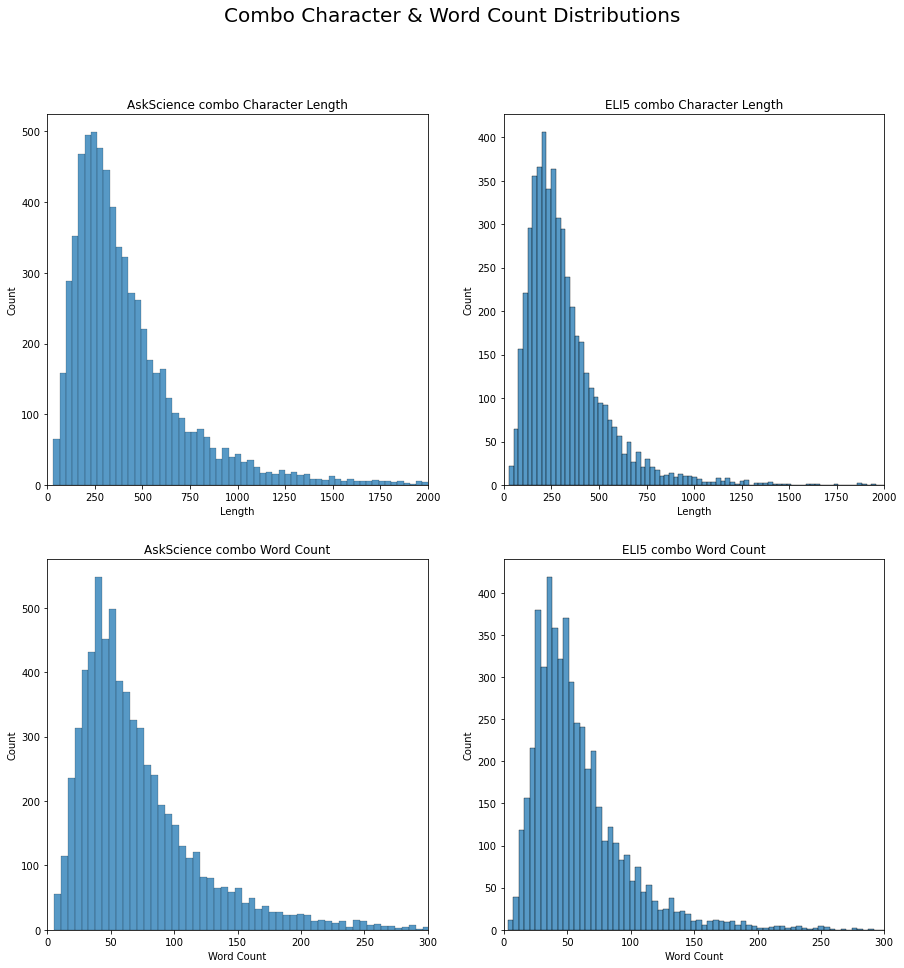

In [27]:
fig, ax = plt.subplots(2, 2, figsize=(15,15))
sns.histplot(ask_df['combo_len'], ax=ax[0,0])
sns.histplot(ex_df['combo_len'], ax=ax[0,1])
sns.histplot(ask_df['combo_words'], ax=ax[1,0])
sns.histplot(ex_df['combo_words'], ax=ax[1,1])

ax[0,0].set(xlabel='Length', xlim=[0,2000], title='AskScience combo Character Length')
ax[0,1].set(xlabel='Length', xlim=[0,2000], title='ELI5 combo Character Length')
ax[1,0].set(xlabel='Word Count', xlim=[0,300], title='AskScience combo Word Count')
ax[1,1].set(xlabel='Word Count', xlim=[0,300], title='ELI5 combo Word Count')

fig.suptitle('Combo Character & Word Count Distributions', fontsize=20);

In [28]:
ask_df.describe()

,created_utc,title_words,title_len,selftext_words,selftext_len,combo_len,combo_words
count,6.802000e+03,6802.000000,6802.000000,6802.000000,6802.000000,6802.000000,6802.000000
mean,1.509692e+09,14.130550,81.276389,61.548662,361.237136,442.513525,75.679212
std,2.997119e+07,7.742759,43.499165,61.587431,373.724661,378.239904,62.100203
min,1.483134e+09,2.000000,13.000000,1.000000,1.000000,32.000000,5.000000
25%,1.492331e+09,9.000000,51.000000,26.000000,144.000000,222.000000,39.000000
50%,1.500948e+09,12.000000,71.000000,45.000000,260.000000,341.000000,59.000000
75%,1.515098e+09,18.000000,102.000000,77.000000,447.000000,534.750000,91.000000
max,1.630429e+09,60.000000,299.000000,1107.000000,6653.000000,6806.000000,1130.000000


In [29]:
ex_df.describe()

,created_utc,title_words,title_len,selftext_words,selftext_len,combo_len,combo_words
count,5.100000e+03,5100.000000,5100.000000,5100.000000,5100.000000,5100.000000,5100.000000
mean,1.626993e+09,12.760392,71.155294,45.689412,252.258039,323.413333,58.449804
std,2.402123e+06,7.112896,39.127639,36.634624,205.534420,211.108356,37.465419
min,1.622887e+09,1.000000,11.000000,1.000000,1.000000,26.000000,3.000000
25%,1.624961e+09,8.000000,45.000000,22.000000,118.000000,186.000000,34.000000
50%,1.626889e+09,11.000000,62.000000,37.000000,198.000000,270.000000,49.000000
75%,1.629050e+09,16.000000,88.000000,59.000000,324.000000,400.250000,72.000000
max,1.631249e+09,54.000000,299.000000,440.000000,2341.000000,2378.000000,445.000000


## Let's initialize a Count Vectorizer to further perform some data analysis

In [30]:
#We want to use the standard stopwords
en_stopwords = stopwords.words('english')

#We also want to remove the ELI5, otherwise it would be a (nearly) 100% indicator
en_stopwords.append('eli5')

#From our analysis we also found some other words that would be beneficial to remove
en_stopwords.append('https')
en_stopwords.append('www')
en_stopwords.append('like')
en_stopwords.append('would')
en_stopwords.append('imgur')
en_stopwords.append('com')
en_stopwords.append('en')
en_stopwords.append('wikipedia')
en_stopwords.append('org')
en_stopwords.append('wiki')
en_stopwords.append('x200b')

cvec = CountVectorizer(stop_words=en_stopwords)

ask_vect = cvec.fit_transform(ask_df['combo'])
ask_vect_df = pd.DataFrame(ask_vect.todense(), columns=cvec.get_feature_names())

ex_vect = cvec.fit_transform(ex_df['combo'])
ex_vect_df = pd.DataFrame(ex_vect.todense(), columns=cvec.get_feature_names())

In [31]:
print('AskScience dataset has a shape of: ', ask_vect_df.shape)
print('ELI5 dataset has a shape of: ', ex_vect_df.shape)

AskScience dataset has a shape of:  (6802, 21735)
ELI5 dataset has a shape of:  (5100, 16747)


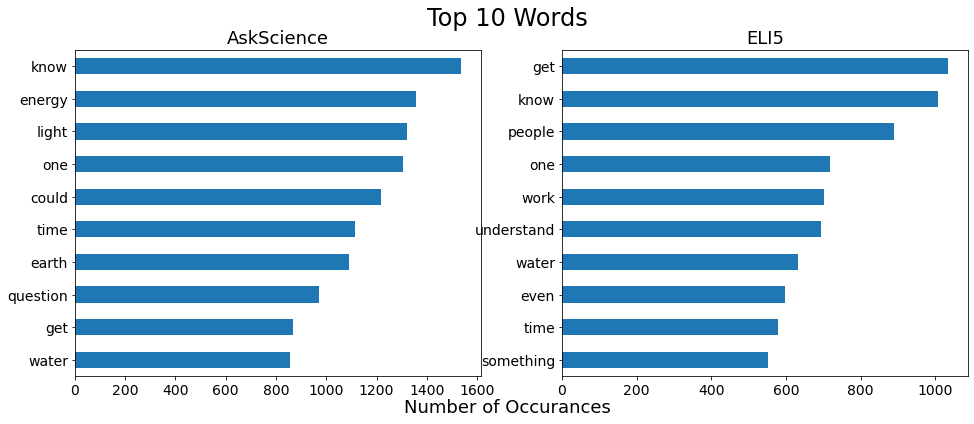

In [32]:
fig, ax = plt.subplots(1,2,figsize=(16,6))
ask_vect_df.sum().sort_values(ascending=False).head(10).plot(kind='barh', ax=ax[0], fontsize=14)
ex_vect_df.sum().sort_values(ascending=False).head(10).plot(kind='barh', ax=ax[1], fontsize=14)

ax[0].set_title('AskScience', fontsize=18)
ax[1].set_title('ELI5', fontsize=18)
ax[0].invert_yaxis()
ax[1].invert_yaxis()

fig.suptitle('Top 10 Words', fontsize=24)
fig.text(0.5,0.04, 'Number of Occurances', ha='center', fontsize=18);

**Interesting. There appears to still be some 'stop words', but they may add value by defining the average author's vocabulary**

---

**How about if we use 2 word phrases via ngram?**

In [33]:
cvec2 = CountVectorizer(stop_words=en_stopwords, ngram_range=(2,2))

ask_vect = cvec2.fit_transform(ask_df['combo'])
ask_vect_df = pd.DataFrame(ask_vect.todense(), columns=cvec2.get_feature_names())

ex_vect = cvec2.fit_transform(ex_df['combo'])
ex_vect_df = pd.DataFrame(ex_vect.todense(), columns=cvec2.get_feature_names())

In [34]:
print('AskScience dataset has a shape of: ', ask_vect_df.shape)
print('ELI5 dataset has a shape of: ', ex_vect_df.shape)

AskScience dataset has a shape of:  (6802, 200627)
ELI5 dataset has a shape of:  (5100, 115997)


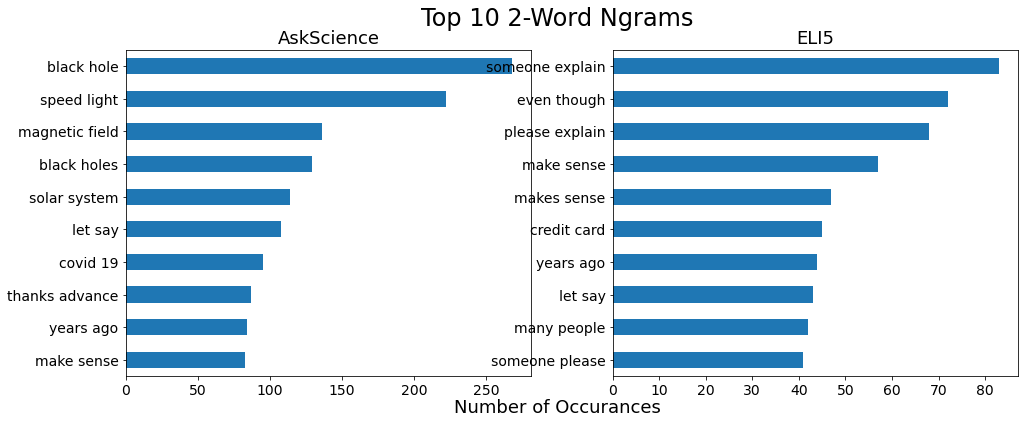

In [35]:
fig2, ax2 = plt.subplots(1,2,figsize=(16,6))
ask_vect_df.sum().sort_values(ascending=False).head(10).plot(kind='barh', ax=ax2[0], fontsize=14)
ex_vect_df.sum().sort_values(ascending=False).head(10).plot(kind='barh', ax=ax2[1], fontsize=14)

ax2[0].set_title('AskScience', fontsize=18)
ax2[1].set_title('ELI5', fontsize=18)
ax2[0].invert_yaxis()
ax2[1].invert_yaxis()

fig2.suptitle('Top 10 2-Word Ngrams', fontsize=24)
fig2.text(0.5,0.04, 'Number of Occurances', ha='center', fontsize=18);

**This seems much more useful than when we only used 1-word ngrams**